# Lane Detection Using Classical Image Processing Techniques

In [1]:
# Importing Libraries- Numpy, MatplotLib and OpenCV

import numpy as np
import matplotlib.pyplot as plt
import cv2

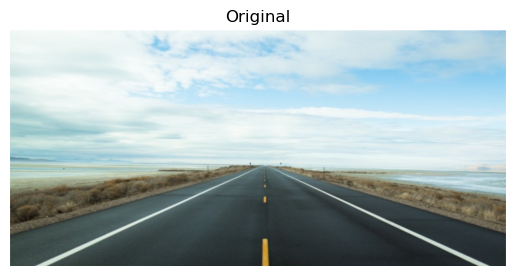

In [2]:
image = cv2.imread('image.png')                       # Importing the image to our notebook
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    # Now here I converted the by default BGR format of image to RGB for viewing it

# Used MatplotLib to view the image
plt.imshow(image_rgb)
plt.title("Original")
plt.axis('off')
plt.show()

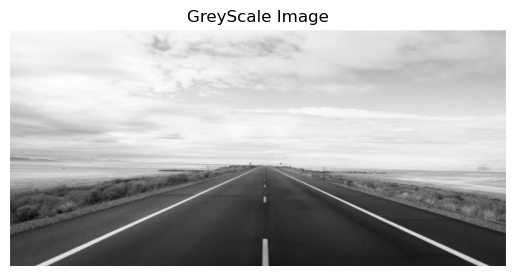

In [3]:
# The image was converted to Grey-Scale for more Robust processing
image_grey= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
plt.imshow(image_grey, cmap='gray')
plt.title("GreyScale Image")
plt.axis('off')
plt.show()

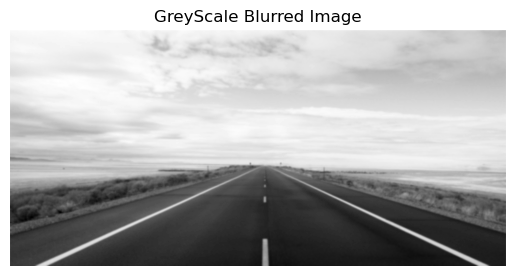

In [4]:
# Gaussian blur was used to reduce the noise from the image so that the canny edge detection process will take in less noise than from the original
image_blur = cv2.GaussianBlur(image_grey, (9,9), 0)
plt.imshow(image_blur, cmap='gray')
plt.title("GreyScale Blurred Image")
plt.axis('off')
plt.show()

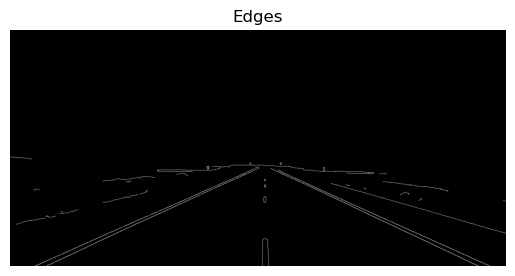

In [5]:
# Canny Edge Detection
low_t=50
high_t=100
edges = cv2.Canny(image_blur, low_t, high_t)
plt.imshow(edges, cmap='gray')
plt.title("Edges")
plt.axis('off')
plt.show()

In [6]:
def region_selection(image):

    # Creating a mask with the same dimensions as the input image; initially all zeros (black).
    mask = np.zeros_like(image)
    
    ignore_mask_color = 255

    # Get the dimensions (rows and columns) of the image.
    rows, cols = image.shape[:2]

    # Defining trapezium that represents the road area.
    bottom_left  = [0, rows]
    top_left     = [cols * 0.4, rows * 0.6]
    top_right    = [cols * 0.6, rows * 0.6]
    bottom_right = [cols, rows]

    # Combining the vertices into a single numpy array.
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)

    # Filling the polygon defined by 'vertices' on the mask with the "ignore_mask_color" (white).
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # Applying the mask to the input image using a bitwise AND operation.
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

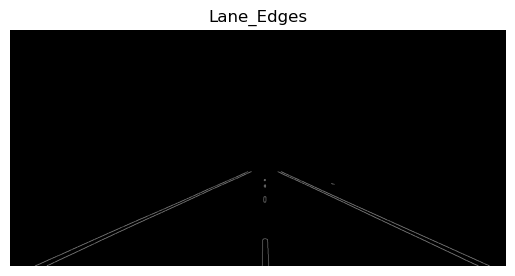

In [7]:
# The edges in the region of Interest
region_edges=region_selection(edges)
plt.imshow(region_edges, cmap='gray')
plt.title("Lane_Edges")
plt.axis('off')
plt.show()

In [8]:
# Applying Hough Transform to detect lines
lines = cv2.HoughLinesP(
    region_edges,  # Input edge image
    rho=1,         # Distance resolution in pixels
    theta=np.pi/180,  # Angle resolution in radians
    threshold=50,   # Minimum number of votes to detect a line
    minLineLength=250,  # Minimum length of a line
    maxLineGap=1000     # Maximum gap between line segments, hight to detect a single long yellow lane lines, since they are discrete
)

# These had been adjusted for detecting a single long yellow lane line and to ignore taking one line as multiple and a lots of other such stuff

In [9]:
# Initializing lists to store slopes and intercepts
slopes = []
intercepts = []

# Looping through detected lines
for line in lines:
    x1, y1, x2, y2 = line[0]
    
    # Calculate slope (m) and intercept (b) of the line: y = mx + b
    if x2 != x1:  # Avoid division by zero
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
        slopes.append(slope)
        intercepts.append(intercept)

# Classifying lines into middle and outer lines
# Middle line: The line with the smallest absolute slope (closest to vertical)
middle_line_index = np.argmax(np.abs(slopes))
middle_line = lines[middle_line_index]

# Outer lines: The other two lines with slope constraints as absolute slope less than 2
outer_lines = [line for i, line in enumerate(lines) if i != middle_line_index and abs(slopes[i]) < 2]


In [10]:
# Creating blank masks
height, width = region_edges.shape
middle_mask = np.zeros((height, width, 3), dtype=np.uint8)  # Black and yellow mask
outer_mask = np.zeros((height, width, 3), dtype=np.uint8)   # Black and white mask

# Drawing the middle line (yellow) on the middle mask
x1, y1, x2, y2 = middle_line[0]
cv2.line(middle_mask, (x1, y1), (x2, y2), (255, 255, 0), thickness=10)  # Yellow color

# Drawing the outer lines (white) on the outer mask
for line in outer_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(outer_mask, (x1, y1), (x2, y2), (255, 255, 255), thickness=10)  # White color

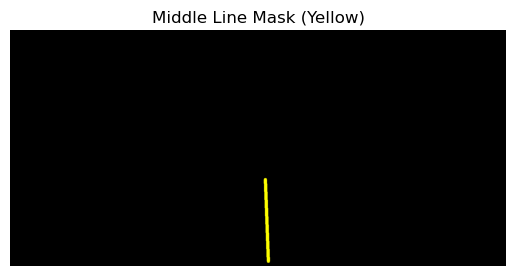

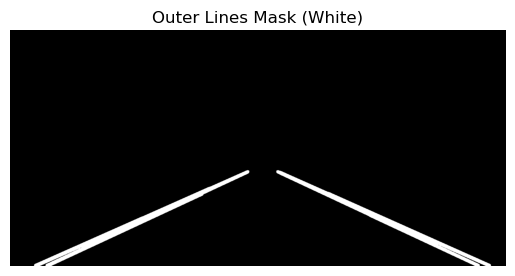

In [12]:
# Display the middle mask (black and yellow)
plt.imshow(middle_mask)
plt.title("Middle Line Mask (Yellow)")
plt.axis('off')
plt.savefig("yellow_lane_mask.png")
plt.show()

# Display the outer mask (black and white)
plt.imshow(outer_mask)
plt.title("Outer Lines Mask (White)")
plt.axis('off')
plt.savefig("White_lane_mask.png")
plt.show()

In [13]:
# Drawing the middle line (yellow) on the original image
x1, y1, x2, y2 = middle_line[0]
cv2.line(image_rgb, (x1, y1), (x2, y2), (0, 255, 255), thickness=10)  # Cyan color

# Drawing the outer lines (white) on the original image
for line in outer_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image_rgb, (x1, y1), (x2, y2), (255, 0, 0), thickness=10)  # Red color

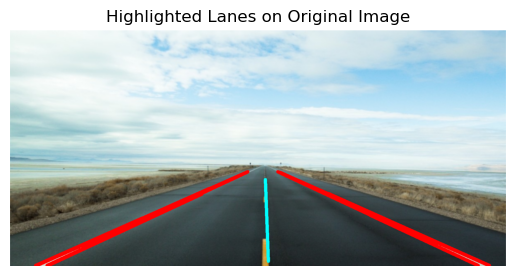

In [15]:
# Displaying the final highlighted image
plt.imshow(image_rgb)
plt.title("Highlighted Lanes on Original Image")
plt.axis('off')
plt.savefig("Highlighted_Lanes_Image.png")
plt.show()